# Data Preparation

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_add_pool
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

import networkx as nx
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
import random
import uproot

In [2]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
path_to_tree = "DecayTreeTuple/tuple"

def rename_columns(df):
    new_columns = {}
    for col in df.columns:
        if "_BDTTag_" in col:
            new_columns[col] = col.replace("_BDTTag_", "_SVtag_")
    df.rename(columns=new_columns, inplace=True)

# maybe don't need
def extract_float(awk_array):
    return awk_array[0] if len(awk_array) > 0 else None

In [51]:
# Read the ROOT file
tree = uproot.open("Dijet_bb_pt20_50_dw.root" + ":" + path_to_tree)
bb_df = tree.arrays(tree.keys(), library="pd")#, entry_start=0, entry_stop=1000) 

# Clean column names and remove unwanted columns
bb_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in bb_df.columns]
rename_columns(bb_df)
columns_to_remove = [col for col in bb_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
bb_df.drop(columns=columns_to_remove, inplace=True)
for col in bb_df.columns:
    if "SVtag" in col:
        bb_df[col] = bb_df[col].apply(extract_float)
tree.close()

# Read the ROOT file
tree = uproot.open("Dijet_qq_pt20_50_dw.root" + ":" + path_to_tree)
qq_df = tree.arrays(tree.keys(), library="pd")#, entry_start=0, entry_stop=1000) 

# Clean column names and remove unwanted columns
qq_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in qq_df.columns]
rename_columns(qq_df)
columns_to_remove = [col for col in qq_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
qq_df.drop(columns=columns_to_remove, inplace=True)
for col in qq_df.columns:
    if "SVtag" in col:
        qq_df[col] = qq_df[col].apply(extract_float)
tree.close()
# 13m

/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

In [52]:
print(f'There are {len(bb_df)} b-jet events (signal)')
print(f'There are {len(qq_df)} light-jet events (background)')

There are 1824752 b-jet events (signal)
There are 2007289 light-jet events (background)


This reads the signal and background data from the csv, then creates a new dataframe with the complete raw data. After combining the signal and background data, it is separated again and assigned truth values in a new column, "IsB". This indicates whether or not it is a b-jet. The data is also selected to only include the leading jet data. Truth matching is done on both the signal and background data, and cuts are applied to only include high momentum jets with a defined pseudorapidity within the range of the detector. The features are defined, including sv tagging as jet-level features.

In [53]:
# Read from csv and assign truth labels
sig_df = bb_df.assign(IsB=1)
bkg_df = qq_df.assign(IsB=0)

# Filter columns to include only leading jet data and truth labels
sig_df = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB")]]
bkg_df = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB")]]

# Apply cuts and truth matching
sig_df = sig_df[(sig_df['Jet0_MC_Match'] == 1) &
                (sig_df['Jet0_MC_Jet_EfB'] > 0.6) &
                (sig_df['Jet0_PT'] > 20000) &
                (sig_df['Jet0_Eta'].between(2.2, 4.4))]
bkg_df = bkg_df[(bkg_df['Jet0_MC_Match'] == 1) &
                (bkg_df['Jet0_MC_Jet_EfB'] < 0.6) &
                (bkg_df['Jet0_MC_Jet_EfD'] < 0.6) &
                (bkg_df['Jet0_PT'] > 20000) &
                (bkg_df['Jet0_Eta'].between(2.2, 4.4))]

# Combine signal and background
combined_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)
#76 m

In [54]:
print(f"Efficiency of signal truth matching is: {len(sig_df)/len(bb_df)}")
print(f"Efficiency of background truth matching is: {len(bkg_df)/len(qq_df)}")
print('')
print(f"Total events after truth matching: {len(combined_df)}")
print(f"Number of b-jets after truth matching: {len(sig_df)}")

Efficiency of signal truth matching is: 0.34502661183547134
Efficiency of background truth matching is: 0.340264406370981

Total events after truth matching: 1312597
Number of b-jets after truth matching: 629588


The csv stores daughter information as a string, so the prepare features function converts them into accessible lists of floats. This function also duplicates jet-level features into lists of floats with lengths equal to the number of nodes in each jet, in order to match the formatting of the daughter-level features, where each float in a list corresponds to a daughter. The data is processed into a new dataframe. Then, the signal and background features are separated again. Training and testing data are created with equal parts of shuffled signal and background data, in a 80:20 ratio of the available leading jet data. The data before processing with signal and background combined includes 600k jets. After the truth matching and cuts are applied, there are 411,540 jets.

In [55]:
# Define feature columns including jet-level and daughter-level features
daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = ['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt']
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

# Prepare features by converting daughter information to lists and duplicating jet-level features
def prepare_features(df, jet_cols, daughter_cols):
    # Duplicate data to lists matching the number of daughters/nodes per jet/row
    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)

    # Convert string values into list of floats
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

df = prepare_features(combined_df, jet_cols, daughter_cols)
#32 m

In [56]:
# Split data into training, validation, and test sets
sig_df = df[df['IsB'] == 1].sample(frac=1, random_state=42).reset_index(drop=True)
bkg_df = df[df['IsB'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)

half_train_size = int((sum(combined_df.IsB)*0.8)/2)
half_test_size = int((sum(combined_df.IsB)*0.2)/2)

# May revise method
train_df = pd.concat([sig_df.head(half_train_size), bkg_df.head(half_train_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of training data is: {len(train_df)}')

test_df = pd.concat([sig_df.tail(half_test_size), bkg_df.tail(half_test_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of testing data is: {len(test_df)}')

validation_df = pd.concat([sig_df.iloc[half_train_size:-half_test_size], bkg_df.iloc[half_train_size:-half_test_size]]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of validation data is: {len(validation_df)}')

Length of training data is: 503670
Length of testing data is: 125916
Length of validation data is: 683011


In [57]:
print('Ratio of c to b in datasets:')
print(f'    Training data: {sum(train_df.IsB)/len(train_df)}')
print(f'    Testing data: {sum(test_df.IsB)/len(test_df)}')
print(f'    Validation data: {sum(validation_df.IsB)/len(validation_df)}')

Ratio of c to b in datasets:
    Training data: 0.5
    Testing data: 0.5
    Validation data: 0.4608930163643045


The node features are processed into an array, so the data can be transformed into data object, representing one row or jet in the data. The feature array is used to create a tensor of the node features. The graphs are created with fully connected edges, but without self-connectioned nodes. The adjacency matrix of the graph is of size [number of nodes] x [number of nodes] filled with ones except the diagonal has zeros. The y tensor holds the truth labels, for graph-level classification. The data is then loaded in batches.

In [58]:
# Create graphs for training and testing
def create_graphs(df, feature_cols):

    features_list = []
    
    for _, row in df.iterrows():
        num_nodes = row['Jet0_nDaughters']
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    data_objects = []
    for idx, features in enumerate(features_list):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Create fully connected graph
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Create graphs for training and testing
train_data = create_graphs(train_df, feature_cols)
test_data = create_graphs(test_df, feature_cols)

# Load data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Classifier

The model is defined with 64 hidden channels, using SAGEConv (sample and aggregate) for the convolutional layers, which aggregates features from its local neighbors. Each iteration of the convolutional layers access the next layer of surrounding nodes. ReLU activation functions are used between each layer, and dropout layers zero out graph representation tensors with a probability of 30% for regularization. After the message passing process, a global add pooling layer and linear layer work together to map the output to a single logit.

In [59]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = SAGEConv(len(feature_cols), hidden_channels)
        self.ln1 = LayerNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.ln2 = LayerNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.ln3 = LayerNorm(hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.ln4 = LayerNorm(hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = Dropout(0.3)

    def forward(self, x, edge_index, batch):        
        x = self.conv1(x, edge_index)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.ln3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        x = self.ln4(x)
        x = F.relu(x)

        x = global_add_pool(x, batch)
        x = self.lin(x)
        return x.squeeze(1)
    
model = GNN()
model = model.to(device)

# Model Evaluation

The model is trained on the graphs using the classifier defined above. During the training loop, the gradients are clipped to prevent exploding gradients and overfitting. Loss is calculated for the training data aand minimized with the AdamW optimizer. In the test function, the loss is calculated for just the validation data, and the accuracy is computed for both. Then, for every epoch, the loss and accuracy values are stored as lists, and the learning rate is decreased when the validation data loss plateaus. The loss and accuracy for the training and validation data are printed, then plotted for all epochs.

In [60]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5) # reduce lr by 0.5 every 5 epochs


# Training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=0.5)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)

    return avg_loss

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y.float())
            pred = (out > 0).float()
            correct = (pred.squeeze() == data.y.float()).sum().item()
            total_correct += correct
            total_samples += len(data.y)
            total_loss += loss.item() * data.num_graphs

        avg_loss = total_loss / len(loader.dataset)
        acc = total_correct / total_samples
    return avg_loss, acc

# Training parameters
num_epochs = 300

# Initialize lists for storing loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

'''best_loss = float('inf')
best_model_weights = None
patience = 15'''

# Training loop
for epoch in range(num_epochs):

    train_loss = train()
    train_loss_values.append(train_loss)

    train_acc = test(train_loader)[1]
    train_acc_values.append(train_acc)

    test_loss, test_acc = test(test_loader)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)

    scheduler.step(test_loss)

    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

torch.save(model.state_dict(), 'fullrun_bq_model1.pth')
print('Model saved as fullrun_bq_model1.pth. Training complete.')

results_df = pd.DataFrame({
    'Epoch': list(range(1, num_epochs+1)),
    'Train Loss': train_loss_values,
    'Test Loss': test_loss_values,
    'Train Accuracy': train_acc_values,
    'Test Accuracy': test_acc_values
})

# Save the loss and accuracy values to a CSV file
results_df.to_csv('fullrun_bq_training_results1.csv', index=False)
#362 m

Epoch: 001, Train Loss: 0.4499, Test Loss: 0.4236, Train Acc: 0.8043, Test Acc: 0.8021
Epoch: 002, Train Loss: 0.4216, Test Loss: 0.4168, Train Acc: 0.8045, Test Acc: 0.8025
Epoch: 003, Train Loss: 0.4168, Test Loss: 0.4138, Train Acc: 0.8066, Test Acc: 0.8054
Epoch: 004, Train Loss: 0.4145, Test Loss: 0.4125, Train Acc: 0.8056, Test Acc: 0.8041
Epoch: 005, Train Loss: 0.4129, Test Loss: 0.4105, Train Acc: 0.8064, Test Acc: 0.8048
Epoch: 006, Train Loss: 0.4118, Test Loss: 0.4099, Train Acc: 0.8064, Test Acc: 0.8045
Epoch: 007, Train Loss: 0.4100, Test Loss: 0.4092, Train Acc: 0.8072, Test Acc: 0.8055
Epoch: 008, Train Loss: 0.4090, Test Loss: 0.4062, Train Acc: 0.8071, Test Acc: 0.8053
Epoch: 009, Train Loss: 0.4071, Test Loss: 0.4075, Train Acc: 0.8064, Test Acc: 0.8052
Epoch: 010, Train Loss: 0.4053, Test Loss: 0.4025, Train Acc: 0.8076, Test Acc: 0.8058
Epoch: 011, Train Loss: 0.4033, Test Loss: 0.3996, Train Acc: 0.8092, Test Acc: 0.8076
Epoch: 012, Train Loss: 0.4008, Test Loss: 

KeyboardInterrupt: 

In [67]:
results_df = pd.DataFrame({
    'Epoch': list(range(1, num_epochs+1)),
    'Train Loss': train_loss_values[200],
    'Test Loss': test_loss_values[200],
    'Train Accuracy': train_acc_values[200],
    'Test Accuracy': test_acc_values[200]
})

# Save the loss and accuracy values to a CSV file
results_df.to_csv('fullrun_bq_training_results1.csv', index=False)

IndexError: range object index out of range

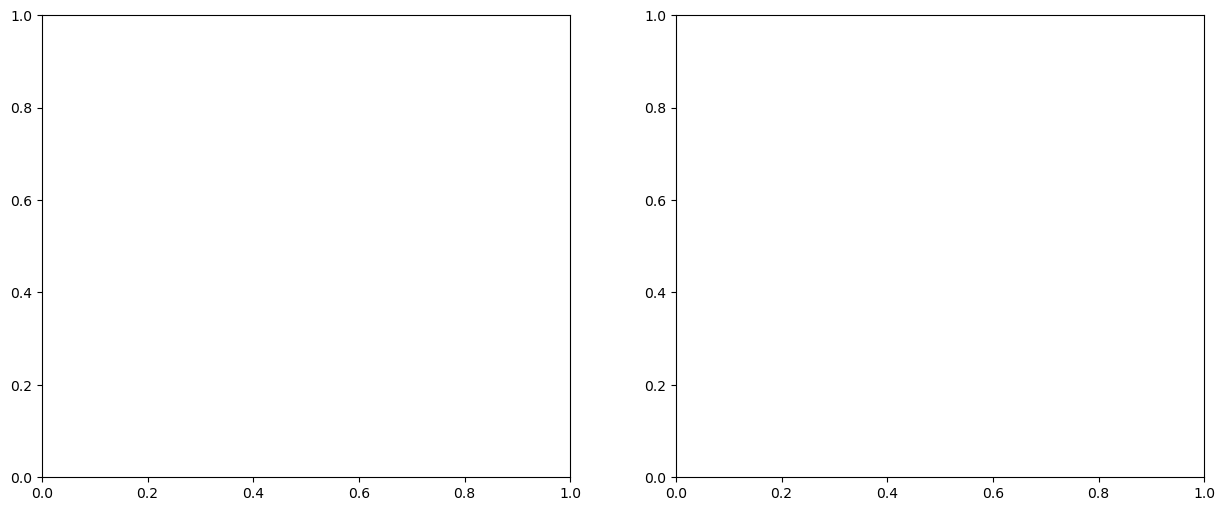

In [87]:
# Plot Loss and Accuracy
def plot_training_results():
    #epochs = range(1, len(train_loss_values) + 1)
    epochs = range(1, 201)

    mean_train_loss = np.mean(train_loss_values)
    mean_test_loss = np.mean(test_loss_values)
    mean_train_acc = np.mean(train_acc_values)
    mean_test_acc = np.mean(test_acc_values)

    min_train_loss = min(train_loss_values)
    min_test_loss = min(test_loss_values)
    max_train_acc = max(train_acc_values)
    max_test_acc = max(test_acc_values)

    final_train_loss = train_loss_values[-1]
    final_test_loss = test_loss_values[-1]
    final_train_acc = train_acc_values[-1]
    final_test_acc = test_acc_values[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    #fig.suptitle('Training Results', fontsize=16)

    # Plot Loss
    ax1.plot(epochs[200], train_loss_values[200], color='darkred', label=(f"Training Loss (min = {min_train_loss:.4f})"))
    ax1.plot(epochs[200], test_loss_values[200], color='mediumblue', label=(f"Testing Loss (min = {min_test_loss:.4f})"))

    ax1.text(0.15, 0.90, "LHCb Simulation", transform=ax1.transAxes, fontsize=15, verticalalignment='bottom')

    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs[200], train_acc_values[200], color='darkred', label=(f"Training Accuracy (max = {max_train_acc:.4f})"))
    ax2.plot(epochs[200], test_acc_values[200], color='mediumblue', label=(f"Testing Accuracy (max = {max_test_acc:.4})"))

    ax2.text(0.7, 0.15, "LHCb Simulation", transform=ax2.transAxes, fontsize=15, verticalalignment='bottom')

    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.style.use('default')
    plt.tight_layout()
    plt.show()
    
# After your training loop, call the function:
plot_training_results()

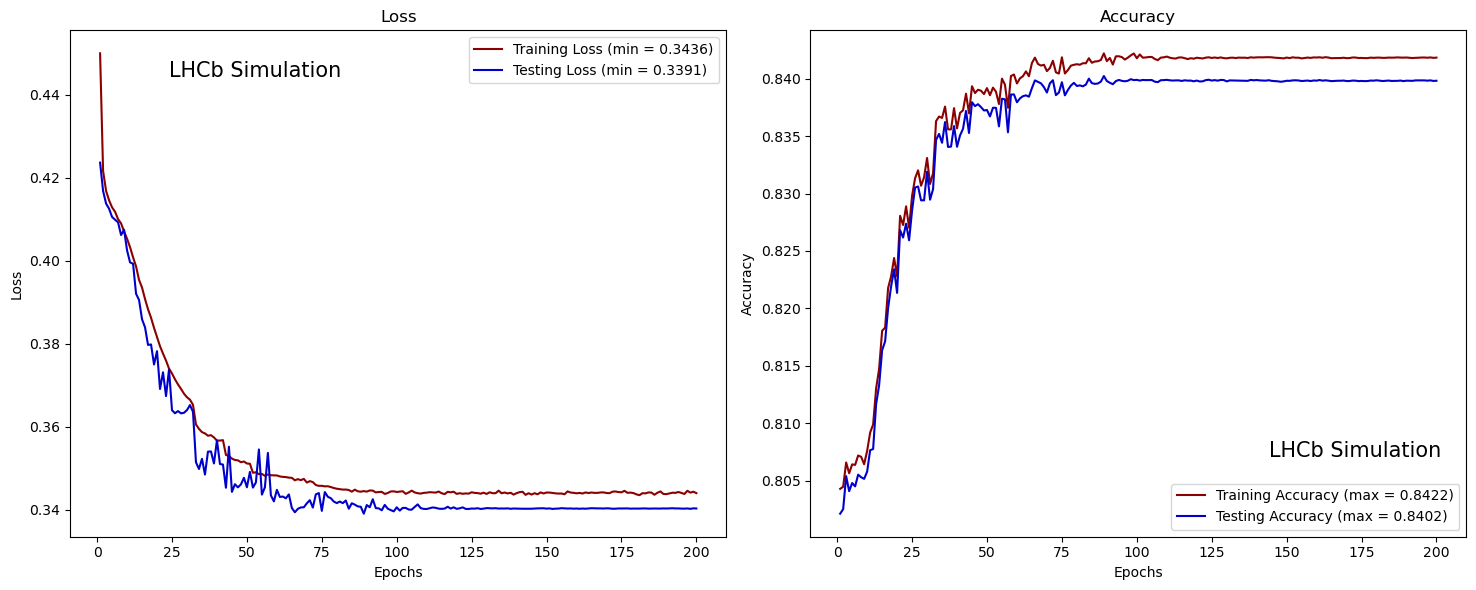

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Loss and Accuracy
def plot_training_results():
    epochs = range(1, 201)  # Only use the first 200 epochs

    # Slicing values for the first 200 epochs
    train_loss_values_200 = train_loss_values[:200]
    test_loss_values_200 = test_loss_values[:200]
    train_acc_values_200 = train_acc_values[:200]
    test_acc_values_200 = test_acc_values[:200]

    min_train_loss = min(train_loss_values_200)
    min_test_loss = min(test_loss_values_200)
    max_train_acc = max(train_acc_values_200)
    max_test_acc = max(test_acc_values_200)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot Loss for first 200 epochs
    ax1.plot(epochs, train_loss_values_200, color='darkred', label=(f"Training Loss (min = {min_train_loss:.4f})"))
    ax1.plot(epochs, test_loss_values_200, color='mediumblue', label=(f"Testing Loss (min = {min_test_loss:.4f})"))
    ax1.text(0.15, 0.90, "LHCb Simulation", transform=ax1.transAxes, fontsize=15, verticalalignment='bottom')

    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot Accuracy for first 200 epochs
    ax2.plot(epochs, train_acc_values_200, color='darkred', label=(f"Training Accuracy (max = {max_train_acc:.4f})"))
    ax2.plot(epochs, test_acc_values_200, color='mediumblue', label=(f"Testing Accuracy (max = {max_test_acc:.4f})"))
    ax2.text(0.7, 0.15, "LHCb Simulation", transform=ax2.transAxes, fontsize=15, verticalalignment='bottom')

    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.style.use('default')
    plt.tight_layout()
    plt.show()

# After your training loop, call the function:
plot_training_results()


In [68]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model = model.to('cpu')
model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

np.save('fullrun_bq_roc_data1.npy', np.array([fpr, tpr, thresholds, auc]))

/tmp/ipykernel_117156/2124502252.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('fullrun_bq_roc_data1.npy', np.array([fpr, tpr, thresholds, auc]))


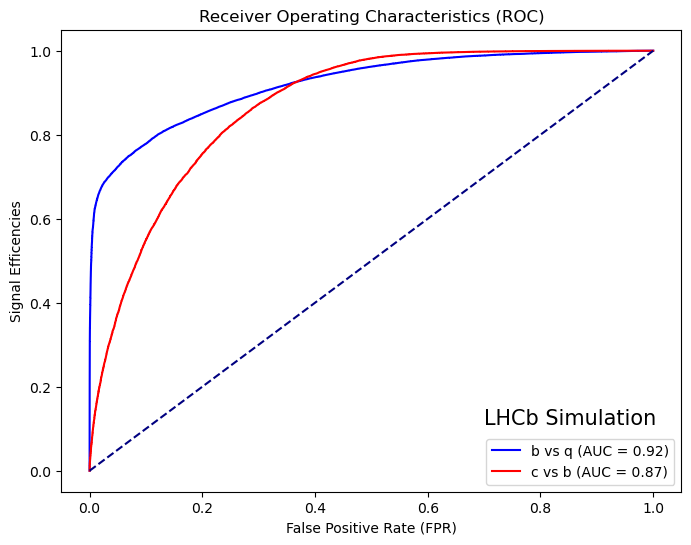

In [90]:
# Load ROC data
fpr1, tpr1, thresholds1, auc1 = np.load('fullrun_bq_roc_data1.npy', allow_pickle=True)
fpr2, tpr2, thresholds2, auc2 = np.load('full_cb_roc_data1.npy', allow_pickle=True)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'b vs q (AUC = {auc1:.2f})', color='blue')
plt.plot(fpr2, tpr2, label=f'c vs b (AUC = {auc2:.2f})', color='red')
plt.plot([0, 1], [0, 1], '--', color='navy')

# Labels and legend
plt.text(0.7, 0.1, "LHCb Simulation", fontsize=15, verticalalignment='bottom')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('Signal Efficencies')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.show()

In [72]:
chosen_tpr = 0.8
closest_index = np.argmin(np.abs(tpr - chosen_tpr))

# Retrieve the threshold and corresponding FPR for this TPR
chosen_threshold = thresholds[closest_index]
chosen_fpr = fpr[closest_index]

print(f"TPR {chosen_tpr}: Pb {chosen_threshold:.4f}: FPR {chosen_fpr:.4f}")

TPR 0.8: Pb 0.4005: FPR 0.1207


In [81]:
# Get FPRs for TPRs
desired_tpr = [.6, .65, .7, 0.75, 0.8, 0.85]

for val in desired_tpr:
    closest_index = np.argmin(np.abs(tpr - val))
    chosen_threshold = thresholds[closest_index]
    chosen_fpr = fpr[closest_index]
    print(f"{val}: {chosen_fpr:.4f}")

0.6: 0.0072
0.65: 0.0141
0.7: 0.0341
0.75: 0.0707
0.8: 0.1207
0.85: 0.2003


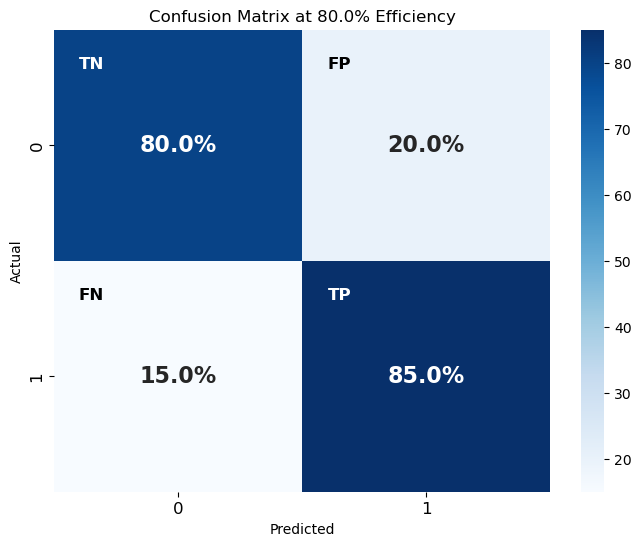

In [84]:
y_pred_binary = (y_scores >= chosen_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)

cm_percentage = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100

annot_labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        percentage = cm_percentage[i, j]
        annot_labels[i, j] = f'{percentage:.1f}%'

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"Confusion Matrix at {chosen_tpr*100}% Efficiency")

ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')

plt.show()

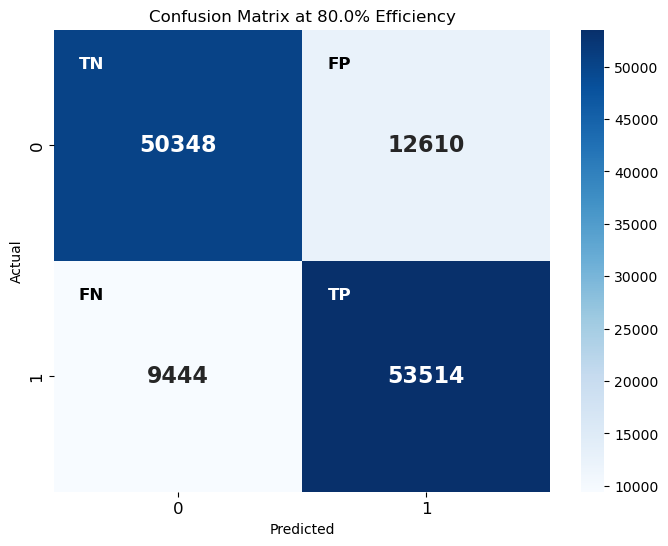

In [85]:
y_pred_binary = (y_scores >= chosen_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)
df_cm = pd.DataFrame(cm)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"Confusion Matrix at {chosen_tpr*100}% Efficiency")

# Add TP, FP, FN, TN labels
ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')

plt.show()

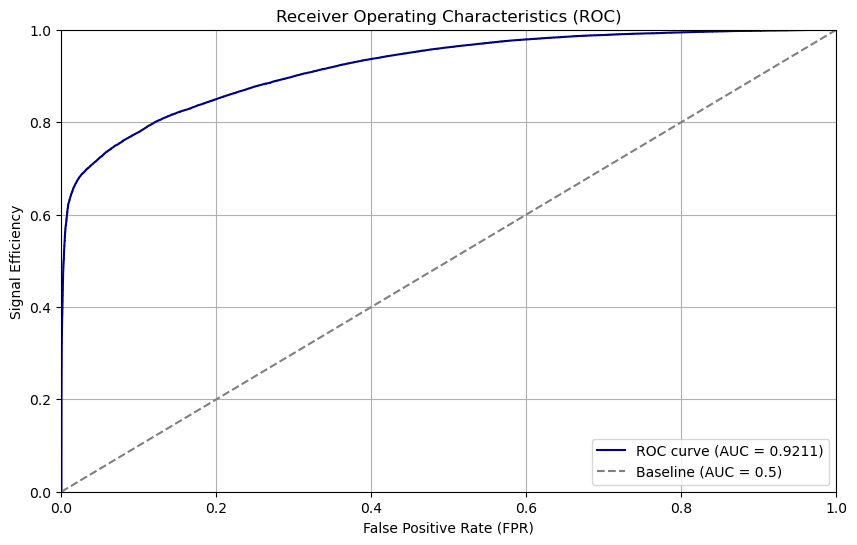

In [76]:
# Plot ROC Curve and show AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.style.use('default')
plt.ylabel('Signal Efficiency')
plt.xlabel('False Positive Rate (FPR)')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

                                Feature  Importance
0                      Jet0_Daughters_E    1.303970
1                     Jet0_Daughters_pT    0.751501
2                     Jet0_Daughters_ID    0.045832
3                     Jet0_Daughters_pX    0.154553
4                     Jet0_Daughters_pY    0.189204
5                     Jet0_Daughters_pZ    1.077062
6                    Jet0_Daughters_Eta    0.014017
7                    Jet0_Daughters_Phi    0.001893
8                      Jet0_Daughters_Q    0.000814
9                     Jet0_Daughters_IP    0.121399
10                Jet0_Daughters_IPCHI2    1.566397
11                 Jet0_Daughters_IPraw    0.079551
12                   Jet0_Daughters_NNe    0.119966
13                   Jet0_Daughters_NNk    0.267595
14                   Jet0_Daughters_NNp    0.374803
15                  Jet0_Daughters_NNpi    0.197052
16                  Jet0_Daughters_NNmu    1.295929
17                  Jet0_Daughters_Chi2    0.266415
18          

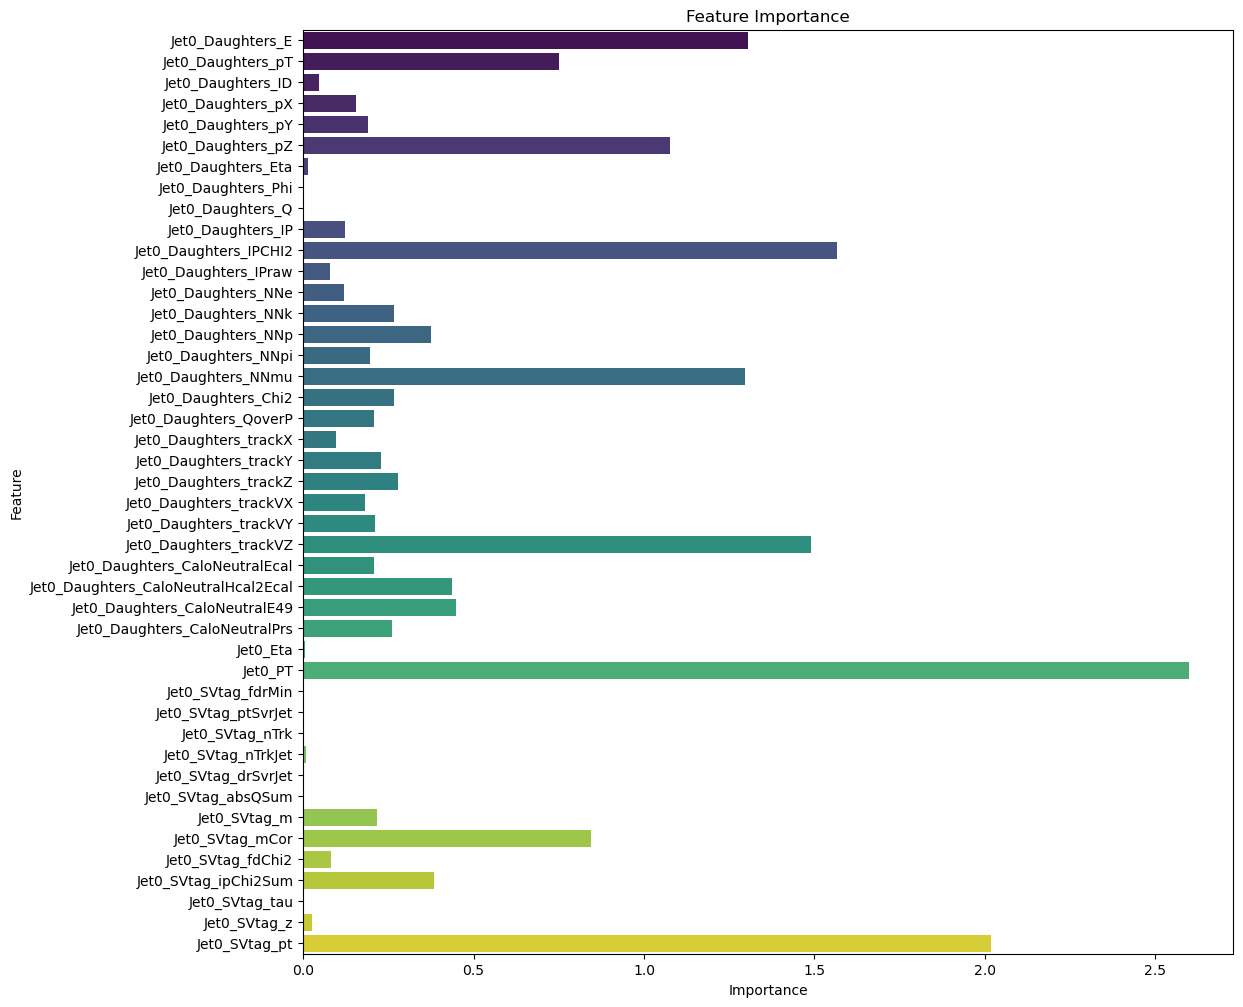

In [77]:
# Prepare model
model.eval()
data = next(iter(test_loader))
x, edge_index, batch = data.x, data.edge_index, data.batch

G = nx.Graph()
edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
G.add_edges_from(edges)

feature_importances = np.zeros(x.size(1))

for feature_idx in range(x.size(1)):
    x_perturbed = x.clone()
    x_perturbed[:, feature_idx] = 0

    # Predict with original features
    with torch.no_grad():
        orig_pred = model(x, edge_index, batch)
        perturbed_pred = model(x_perturbed, edge_index, batch)

    # Compute importance - difference in predictions
    importance = torch.mean(torch.abs(orig_pred - perturbed_pred))
    feature_importances[feature_idx] = importance

importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feature_importances})
print(importance_df)

plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [78]:
for index, row in importance_df.iterrows():
    feature = row['Feature'] 
    importance = row['Importance']
    if importance > 0.25:
        print(f'{feature} & {importance:4f}')

Jet0_Daughters_E & 1.303970
Jet0_Daughters_pT & 0.751501
Jet0_Daughters_pZ & 1.077062
Jet0_Daughters_IPCHI2 & 1.566397
Jet0_Daughters_NNk & 0.267595
Jet0_Daughters_NNp & 0.374803
Jet0_Daughters_NNmu & 1.295929
Jet0_Daughters_Chi2 & 0.266415
Jet0_Daughters_trackZ & 0.277924
Jet0_Daughters_trackVZ & 1.490818
Jet0_Daughters_CaloNeutralHcal2Ecal & 0.437642
Jet0_Daughters_CaloNeutralE49 & 0.447610
Jet0_Daughters_CaloNeutralPrs & 0.261318
Jet0_PT & 2.598422
Jet0_SVtag_mCor & 0.843009
Jet0_SVtag_ipChi2Sum & 0.384685
Jet0_SVtag_pt & 2.019049


# Model Probability Output

This function  inputs a random jet sample from the full dataframe before truth matching or cuts are applied and uses the trained model to output predictions of if the jet is a b-jet or not.

In [41]:
chosen_tpr

0.8

In [42]:
chosen_threshold

0.11975377

In [47]:
print(df.Jet0_nDaughters)

0       14
1       17
2       17
3       13
4       22
        ..
1995    17
1996    17
1997    13
1998    29
1999    16
Name: Jet0_nDaughters, Length: 2000, dtype: int32

In [48]:
df = pd.concat([bb_df, qq_df]).reset_index(drop=True)

def make_predictions():
    # Select a random integer for sampling
    random_integer = np.random.randint(0, len(df))
    sample_jet = df.iloc[random_integer:random_integer+1].copy()

    # Filter columns related to Jet0
    sample_jet = sample_jet.filter(like='Jet0')

    # Define feature columns
    daughter_cols = [col for col in sample_jet.columns if "_Daughters" in col]
    svtag_cols = ['Jet0_SVtag_fdrMin',
    'Jet0_SVtag_ptSvrJet',
    'Jet0_SVtag_nTrk',
    'Jet0_SVtag_nTrkJet',
    'Jet0_SVtag_drSvrJet',
    'Jet0_SVtag_absQSum',
    'Jet0_SVtag_m',
    'Jet0_SVtag_mCor',
    'Jet0_SVtag_fdChi2',
    'Jet0_SVtag_ipChi2Sum',
    'Jet0_SVtag_tau',
    'Jet0_SVtag_z',
    'Jet0_SVtag_pt']
    jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
    feature_cols = daughter_cols + jet_cols

    print(df.Jet0_nDaughters)
    for col in jet_cols:
        sample_jet[col] = sample_jet.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)
    print(df.Jet0_nDaughters)
    for col in daughter_cols:
        sample_jet[col] = sample_jet[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

    # Obtain features of each node within the graph
    features_list = []
    for _, row in sample_jet.iterrows():
        num_nodes = int(row['Jet0_nDaughters'])
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    # Create graph representation with data objects
    data_objects = []
    for features in features_list:
        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        data = Data(x=x, edge_index=edge_index)
        data_objects.append(data)

    for data in data_objects:
        with torch.no_grad():
            output = model(data.x, data.edge_index, data.batch)
            probability = torch.sigmoid(output)
            prediction = (probability > chosen_threshold).int()

    print(f'Probability: {probability.item()}')
    if prediction.item() == 1:  
        print(f'Prediction: b-jet')
    if prediction.item() == 0:  
        print(f'Prediction: not a b-jet')
    return probability.item()

i = 0

for i in range(100):
    bprob = make_predictions()
    qprob = make_predictions()

0       14
1       17
2       17
3       13
4       22
        ..
1995    17
1996    17
1997    13
1998    29
1999    16
Name: Jet0_nDaughters, Length: 2000, dtype: int32


ValueError: cannot reshape array of size 17 into shape (1,1)

In [60]:
# Separate b and q data from testing dataset (preprocessed)
b = validation_df[validation_df.IsB == 1]
q = validation_df[validation_df.IsB == 0]

b_data = create_graphs(b, feature_cols)
q_data = create_graphs(q, feature_cols)

b_prob = []
q_prob = []

model.eval()
with torch.no_grad():
    for data in b_data:
        out = model(data.x, data.edge_index, data.batch)
        bprob = torch.sigmoid(out)
        b_prob.append(bprob.numpy().flatten())
    for data in q_data:
        out = model(data.x, data.edge_index, data.batch)
        qprob = torch.sigmoid(out)
        q_prob.append(qprob.numpy().flatten())

b_prob = np.concatenate(b_prob)
q_prob = np.concatenate(q_prob)

In [ ]:
b_values, b_bins, _ = plt.hist(b_prob, bins=100, label='b-jets', color='darkred', histtype='step');
q_values, q_bins, _ = plt.hist(q_prob, bins=100, label='q-jets', color='mediumblue', histtype='step');

In [75]:
# Find the cutoff for desired efficiency (sum under Pb)
b_bin_area = np.cumsum(np.diff(b_bins) * b_values)
sum(b_bin_area[:64])/sum(b_bin_area)

0.40272582755585945

In [76]:
eighty_eff = b_bins[47]
print(eighty_eff)
seventy_eff = b_bins[56]
print(seventy_eff)
sixty_eff = b_bins[64]
print(sixty_eff)

0.4764377772808075
0.5653440356254578
0.6443718671798706


/var/folders/w5/gw0llq6120v4569jh69f877m0000gq/T/ipykernel_59890/263920917.py:15: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e4)


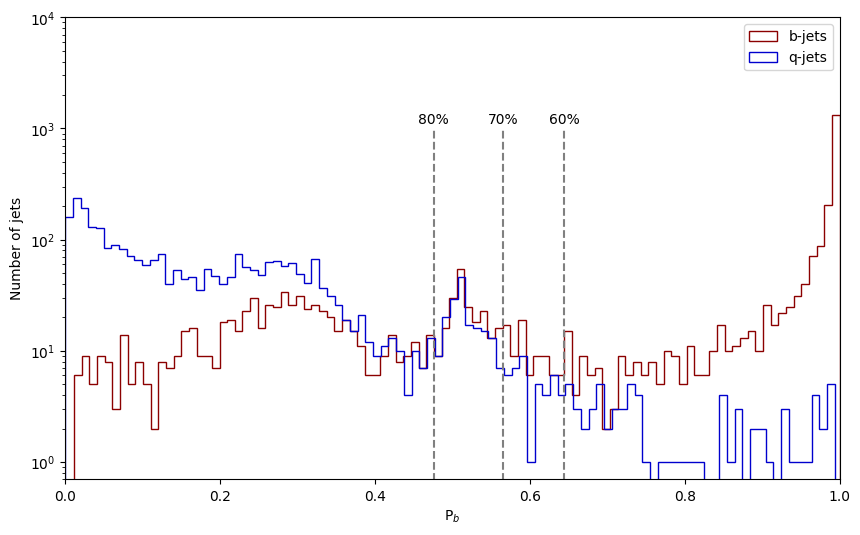

In [78]:
plt.figure(figsize=(10, 6))
b_values, b_bins, _ = plt.hist(b_prob, bins=100, label='b-jets', color='darkred', histtype='step')
q_values, q_bins, _ = plt.hist(q_prob, bins=100, label='q-jets', color='mediumblue', histtype='step')
plt.vlines(x=eighty_eff, ymin=0, ymax=1000, color='grey', linestyle='--')
plt.text(eighty_eff, 1200, '80%', horizontalalignment='center', verticalalignment='center')

plt.vlines(x=seventy_eff, ymin=0, ymax=1000, color='grey', linestyle='--')
plt.text(seventy_eff, 1200, '70%', horizontalalignment='center', verticalalignment='center')

plt.vlines(x=sixty_eff, ymin=0, ymax=1000, color='grey', linestyle='--')
plt.text(sixty_eff, 1200, '60%', horizontalalignment='center', verticalalignment='center')

plt.yscale('log')
plt.xlim(0,1)
plt.ylim(0,1e4)
plt.ylabel('Number of jets')
plt.xlabel('P$_b$')
plt.legend(loc='best')
#plt.title('Probability Distribution')
plt.show()